Epoch 1/10: 100%|██████████| 235/235 [00:01<00:00, 163.59it/s]


Epoch 1: Train Loss=2.9479, Train Acc=0.1780, Val Loss=2.1158, Val Acc=0.3904


Epoch 2/10: 100%|██████████| 235/235 [00:01<00:00, 193.34it/s]


Epoch 2: Train Loss=1.6341, Train Acc=0.5319, Val Loss=1.3218, Val Acc=0.6200


Epoch 3/10: 100%|██████████| 235/235 [00:01<00:00, 177.61it/s]


Epoch 3: Train Loss=1.0615, Train Acc=0.6983, Val Loss=0.9796, Val Acc=0.7152


Epoch 4/10: 100%|██████████| 235/235 [00:01<00:00, 184.82it/s]


Epoch 4: Train Loss=0.7794, Train Acc=0.7759, Val Loss=0.8486, Val Acc=0.7580


Epoch 5/10: 100%|██████████| 235/235 [00:01<00:00, 184.91it/s]


Epoch 5: Train Loss=0.6008, Train Acc=0.8268, Val Loss=0.7574, Val Acc=0.7808


Epoch 6/10: 100%|██████████| 235/235 [00:01<00:00, 190.17it/s]


Epoch 6: Train Loss=0.4798, Train Acc=0.8632, Val Loss=0.6713, Val Acc=0.8052


Epoch 7/10: 100%|██████████| 235/235 [00:01<00:00, 192.14it/s]


Epoch 7: Train Loss=0.3918, Train Acc=0.8871, Val Loss=0.6386, Val Acc=0.8152


Epoch 8/10: 100%|██████████| 235/235 [00:01<00:00, 194.24it/s]


Epoch 8: Train Loss=0.3112, Train Acc=0.9099, Val Loss=0.6546, Val Acc=0.8084


Epoch 9/10: 100%|██████████| 235/235 [00:01<00:00, 190.78it/s]


Epoch 9: Train Loss=0.2399, Train Acc=0.9321, Val Loss=0.6427, Val Acc=0.8180


Epoch 10/10: 100%|██████████| 235/235 [00:01<00:00, 189.14it/s]


Epoch 10: Train Loss=0.2056, Train Acc=0.9433, Val Loss=0.6023, Val Acc=0.8280


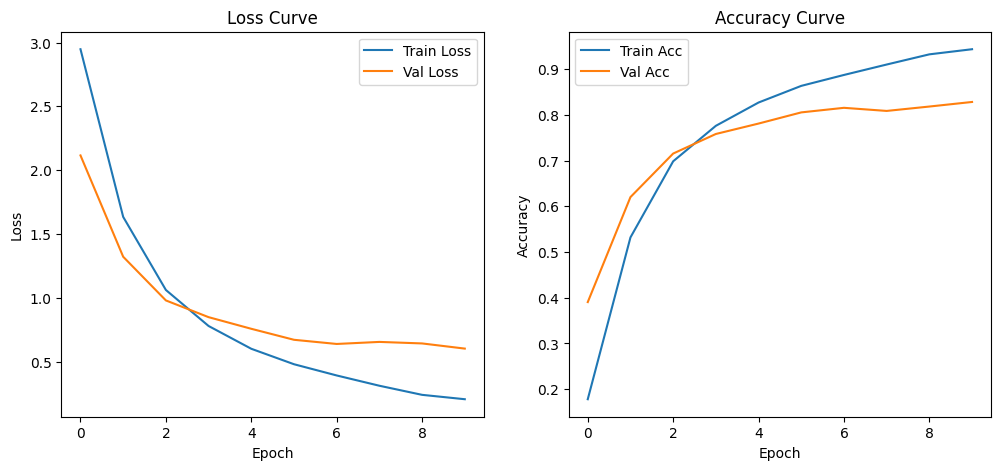

Test Prediction: 100%|██████████| 4890/4890 [00:05<00:00, 963.74it/s] 

['down', 'down', 'go', 'down', 'down', 'down', 'down', 'down', 'down', 'down']
Audio: 022cd682_nohash_0.wav, Predicted Class: down


Audio: 0c40e715_nohash_0.wav, Predicted Class: down


Audio: 0c540988_nohash_0.wav, Predicted Class: go


Audio: 0cb74144_nohash_0.wav, Predicted Class: down


Audio: 0cb74144_nohash_1.wav, Predicted Class: down


Audio: 0cb74144_nohash_2.wav, Predicted Class: down


Audio: 0cb74144_nohash_3.wav, Predicted Class: down


Audio: 0cb74144_nohash_4.wav, Predicted Class: down


Audio: 0ea0e2f4_nohash_0.wav, Predicted Class: down


Audio: 0f250098_nohash_0.wav, Predicted Class: down


In [5]:
# --- Markdown Cell ---
# # Speech Command Classification with RNN
# This notebook demonstrates how to classify spoken keywords using MFCC features and a Recurrent Neural Network (RNN) in PyTorch.

# --- Code Cell ---
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Markdown Cell ---
# ## 1. Data Preparation

# --- Code Cell ---
# Paths
data_path = Path('data/Speech_detection_dataset')
train_dataset_path = data_path / 'train_dataset'
test_dataset_path = data_path / 'test_dataset'

# List audio files
train_audio_path_list = list(train_dataset_path.glob("*/*.wav"))
test_audio_path_list = list(test_dataset_path.glob("*/*.wav"))

# Get class names
class_names = sorted([p.name for p in train_dataset_path.iterdir() if p.is_dir()])

# --- Code Cell ---
# Sample 10,000 random training files for speed
def random_sample_generator(path, seed, k=10000):
    random.seed(seed)
    return random.sample(path, k=k)

random_train_audio_path_list = random_sample_generator(train_audio_path_list, seed=0)

# --- Code Cell ---
# Load audio and extract class label
def load_audio_info(audio_path):
    data, sample_rate = librosa.load(str(audio_path))
    class_label = audio_path.parent.name
    return {'data': data, 'sample_rate': sample_rate, 'class_name': class_label}

# --- Code Cell ---
# Parallel loading
def creating_df(path_list):
    import concurrent.futures
    with concurrent.futures.ThreadPoolExecutor() as executor:
        data_list = list(executor.map(load_audio_info, path_list))
    df = pd.DataFrame(data_list)
    return df

training_df = creating_df(random_train_audio_path_list)
test_df = creating_df(test_audio_path_list)

# --- Code Cell ---
# Extract MFCC features
def mfcc_calculator(row):
    data = row['data']
    sample_rate = row['sample_rate']
    class_name = row['class_name']
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    return {'mfcc_data': mfcc, 'class_name': class_name}

def mfcc_df_creator(dataframe):
    import concurrent.futures
    with concurrent.futures.ThreadPoolExecutor() as executor:
        mfcc_data_list = list(executor.map(mfcc_calculator, dataframe.to_dict('records')))
    mfcc_df = pd.DataFrame(mfcc_data_list)
    return mfcc_df

train_mfcc_df = mfcc_df_creator(training_df)
test_mfcc_df = mfcc_df_creator(test_df)

# --- Markdown Cell ---
# ## 2. Preprocessing for RNN

# --- Code Cell ---
# Pad or truncate MFCCs to the same time dimension, then transpose for RNN
def pad_or_truncate_for_rnn(mfcc, target_length):
    n_mfcc, cur_length = mfcc.shape
    if cur_length < target_length:
        pad_width = target_length - cur_length
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    elif cur_length > target_length:
        mfcc = mfcc[:, :target_length]
    return mfcc.T  # [time, n_mfcc]

max_length = 44  # Use a fixed length for all samples

X = train_mfcc_df['mfcc_data']
y = train_mfcc_df['class_name']

X = [pad_or_truncate_for_rnn(mfcc, max_length) for mfcc in X]
y = list(y)

# --- Code Cell ---
# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

# --- Code Cell ---
# Encode labels
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
y_train_idx = [class_to_idx[label] for label in y_train]
y_val_idx = [class_to_idx[label] for label in y_val]

# --- Code Cell ---
# Convert to tensors
X_train_tensor = torch.tensor(np.stack(X_train), dtype=torch.float32)  # [batch, time, n_mfcc]
y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
X_val_tensor = torch.tensor(np.stack(X_val), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_idx, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Markdown Cell ---
# ## 3. RNN Model Definition

# --- Code Cell ---
import torch
import torch.nn as nn

class AudioCRNN(nn.Module):
    def __init__(self, input_channels, input_mfcc, cnn_hidden, rnn_hidden, rnn_layers, num_classes):
        super().__init__()
        # CNN part: extract spatial features from MFCCs
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, cnn_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(cnn_hidden),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # Reduce both freq and time dims
        )
        # RNN part: process sequence of CNN features
        self.rnn = nn.GRU(
            input_size=cnn_hidden * (input_mfcc // 2),  # input_mfcc: number of MFCCs, divided by pooling
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(rnn_hidden * 2, num_classes)  # *2 for bidirectional

    def forward(self, x):
        # x: [batch, 1, n_mfcc, time]
        x = self.cnn(x)  # [batch, cnn_hidden, n_mfcc/2, time/2]
        # Rearrange for RNN: treat time as sequence, flatten freq and channel dims
        b, c, f, t = x.size()
        x = x.permute(0, 3, 1, 2)  # [batch, time, channel, freq]
        x = x.reshape(b, t, c * f)  # [batch, time, features]
        out, _ = self.rnn(x)        # [batch, time, rnn_hidden*2]
        out = out[:, -1, :]         # Use last time step
        out = self.fc(out)          # [batch, num_classes]
        return out

# Example usage:
input_mfcc = 40  # number of MFCCs
model = AudioCRNN(
    input_channels=1,
    input_mfcc=input_mfcc,     # changed ctor signature
    cnn_hidden=32,
    rnn_hidden=64,
    rnn_layers=2,
    num_classes=len(class_names)
).to(device)

# # Example input: [batch, 1, n_mfcc, time]
# x = torch.randn(8, 1, input_mfcc, 44)
# out = model(x)
# print(out.shape)  # [8, 35]

# --- Markdown Cell ---
# ## 4. Training

# --- Code Cell ---
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    total = 0
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        x_in = X_batch.permute(0, 2, 1).unsqueeze(1)  # -> [B, 1, n_mfcc, time]
        out = model(x_in)
        loss = loss_fn(out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = out.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    train_loss /= len(train_loader)
    train_acc = train_correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.inference_mode():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            x_in = X_batch.permute(0, 2, 1).unsqueeze(1)
            out = model(x_in)
            loss = loss_fn(out, y_batch)
            val_loss += loss.item()
            preds = out.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

# --- Markdown Cell ---
# ## 5. Plotting Loss and Accuracy

# --- Code Cell ---
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

# --- Markdown Cell ---
# ## 6. Evaluation on Test Set

# --- Code Cell ---
# Prepare test MFCC features for RNN
X_test = [pad_or_truncate_for_rnn(mfcc, max_length) for mfcc in test_mfcc_df['mfcc_data']]
X_test_tensor = torch.tensor(np.stack(X_test), dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
y_pred_class = []
with torch.inference_mode():
    for X_batch in tqdm(test_loader, desc="Test Prediction"):
        X_batch = X_batch[0].to(device)
        x_in = X_batch.permute(0, 2, 1).unsqueeze(1)  # -> [B, 1, n_mfcc, time]
        out = model(x_in)
        # out = model(X_batch)
        pred = out.argmax(dim=1).item()
        y_pred_class.append(class_names[pred])

print(y_pred_class[:10])  # Show first 10 predictions

# --- Markdown Cell ---
# ## 7. Listen and Display Predictions

# --- Code Cell ---
import IPython.display as ipd

for i in range(10):  # Show first 10 test samples
    print(f"Audio: {test_audio_path_list[i].name}, Predicted Class: {y_pred_class[i]}")
    display(ipd.Audio(test_audio_path_list[i]))